# Fitting functions with a quantum circuit
___________________________________

_This notebook is part of the Q-Hack 2021 presentation (link to the presentation will be added soon)._

In this notebook, I will present simple circuits to encode the data into a quantum circuit utilizing the angles in the rotational gates. With that, we can check if the quantum circuit can approximate a given function. The explicit circuits presented are for only one qubit, but its generalization to multiple-qubits follows.

This notebook is based on the references:

- _One qubit as a Universal Approximant_, A. Pérez-Salinas, D. López-Núñez, A. García-Sáez, P. Forn-Díaz, J. I. Latorre, [arXiv:2102.04032 [quant-ph]](https://arxiv.org/abs/2102.04032) (2021).
- _The effect of data encoding on the expressive power of variational quantum machine learning models_, M. Schuld, R. Sweke, J. J. Meyer, [arXiv:2008.08605 [quant-ph]](https://arxiv.org/abs/2008.08605) (2020).
- _Data re-uploading for a universal quantum classifier_, A. Pérez-Salinas, A. Cervera-Lierta, E. Gil-Fuster, J. I. Latorre, [Quantum 4, 226 (2020)](https://quantum-journal.org/papers/q-2020-02-06-226/).

You will need to install [Tequila](https://github.com/aspuru-guzik-group/tequila) package to run it.

In [48]:
import tequila as tq
import numpy as np
import matplotlib.pyplot as plt
from numpy import random

## Quantum Circuit

We will encode the data into the rotational gates of a quantum circuit.
As an example, for one qubit, we select the following encoding:
$$ U\left(\vec{\theta},x\right) = R_{y}\left(\theta^{(1)}\right)R_{z}\left(\theta^{(2)}x + \theta^{(3)}\right), $$
where $x$ is a given data point (in this case, we consider 1D data), $\vec{\theta}=\left(\theta^{(1)}, \theta^{(2)}, \theta^{(3)}\right)$ and $R_{k}\left(\theta\right)=e^{i\frac{\theta}{2}\sigma_{k}}$ with $k=x,y,z$.

The strategy will be the following: the total quantum circuit will be a concatenation of $U$ gates that feed the circuit with the data and some parameters to be optimized, i.e.
$$ U_{feed}\left(\vec{\theta}_{1},\cdots,\vec{\theta}_{L};x\right) = U\left(\vec{\theta}_{L},x\right)U\left(\vec{\theta}_{L-1},x\right)\cdots U\left(\vec{\theta}_{1},x\right). $$
We need to establish the number of _layers_ $L$ of our circuit and we will have to find the optimal values of the $3L$ parameters. We expect that the larger the number of layers, the more sophisticated will be the encoding and the higher the accuracy of the function.

In [49]:
def qcircuit(x, layers, param):
    qc = tq.QCircuit()
    p = 0 # all parameters are stored in a single list
    for l in range(layers): # add layers to the circuit
        qc += tq.gates.Ry(param[p],0) + tq.gates.Rz(x*param[p+1]+param[p+2],0) # feed the troll!
        p = p + 3
    return qc

## Learning the function

Once we have the data encoded into the quantum circuit (a.k.a. _feature map_), we have to design a cost function that will allow us to optimize the circuit parameters.

Since we are dealing with only one qubit, a simple approach is to measure it on the computational basis and depending on the expectation value of $Z$ operator, we compare it with the value of the target function to learn. This function has to be rescaled between -1 and 1 accordingly. Thus, we construct the cost function by taking a set of data training points $\left(x_{1},\cdots,x_{M}\right)$, running out $U_feed$ circuit with each of them and computing the expectation value of $Z$ with the resultant state:
$$\mathcal{L}oss\left(\vec{\theta}_{1},\cdots,\vec{\theta}_{L}\right)=\sum_{i=1}^{M}\left(|\langle 0|U_{feed}^{\dagger}(x_{i})ZU_{feed}(x_{i})|0\rangle|^2 - f(x_{i})\right)^2, $$
were I ommited the $\theta$ dependency in $U_{feed}$.

In [50]:
# Function
def f(x):
    func = np.sin(10*x)/(10*x)
    return func

# Cost function
def loss(xval,layers,param):
    obj = 0
    for i in range(len(xval)):
        qc = qcircuit(xval[i],layers, param)
        expval = tq.ExpectationValue(qc, H=tq.paulis.Z(0))
        obj += (expval-f(xval[i]))**2
    return obj/len(xval)

We are ready for the circuit optimization! To compare how the accuracy changes with the number of layers, we will optimize for up to `laymax` layers. We have also to create the training data set (in this example, we will take random points between -1 and 1)

In [51]:
training_set = 25 # number of training points
laymax = 4

# generate the training data
xval=[]
for i in range(training_set):
    rand = random.uniform(-1,1)
    xval.append(rand)

# Optimization details    
grad = '2-point' # numerical gradient (= None: analytical gradient)
mthd = 'BFGS' # minimization method
mthd_opt = {'eps':1.e-4} # method options (that's the stepsize for the gradients)

train_param = [[]]*(laymax+1)
for l in range(1,laymax+1):
    
    # Generate the needed variables
    param = [tq.Variable(name='th{}'.format(i)) for i in range(0,3*l)]
    # Initialize them at random
    param0 = {key : random.uniform(0, 2*np.pi) for key in param}
    
    # Optimize!
    train = tq.minimize(objective=loss(xval,l,param), initial_values = param0, method = mthd, gradient = grad, method_options = mthd_opt, silent=True)
  
    print("{}".format(l)," layers")
    print("Loss function = ", train.energy)
    
    train_param[l] = train.angles # saving the parameters 

1  layers
Loss function =  0.07102613126521413
2  layers
Loss function =  0.03218041825628407
3  layers
Loss function =  0.001899347558935098
4  layers
Loss function =  0.0016025018077730907


## Test and results

Once we have the optimized parameters, we can proceed to test the results by running new circuits with other data values.

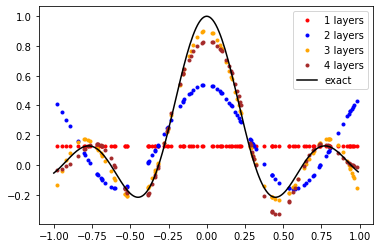

In [57]:
test_set = 100 # number of test points

col = ['red','blue','orange','brown']

# generate the test data
xtest=[]
for i in range(test_set):
    rand = random.uniform(-1,1)
    xtest.append(rand)   
    
for l in range(1,laymax+1):
    param = [tq.Variable(name='th{}'.format(i)) for i in range(0,3*l)]
    ytrain=[]
    for i in range(test_set):
        
        qc = qcircuit(xtest[i], l, param)
        expval = tq.ExpectationValue(qc, H=tq.paulis.Z(0))
        res_test = tq.simulate(expval,variables=train_param[l])
        
        ytrain.append(res_test)
        
    plt.plot(xtest, ytrain, '.', color=col[l-1], label = "{} layers".format(l))

ytrue=[]
xtrue=[]
for i in range(1000):
    xtrue.append(random.uniform(-1,1))
xtrue.sort()
for i in range(1000):
    ytrue.append(f(xtrue[i]))
    
xfunc = np.arange(-1., 1., 0.01)
plt.plot(xfunc,f(xfunc), '-', color='black', label ="exact") 
plt.legend()
plt.show()

## Conclusions and some open questions

As you can see, one qubit has the capability of learning an arbitrary function. The data re-uploading strategy used (repeating the same encoding multiple times) increases the accuracy as more layers are considered. This result comes from the fact that a qubit can represent the Fourier series, which in turn can represent arbitrary continuous functions. It can also be proved the universality of a single-qubit as a function approximator by means of the Universal Approximation Theorem.

- These are the results for only one qubit, what happens if we consider more and entanglement between layers? Do we require more or fewer parameters to learn the function with similar accuracy?
- We used a particular encoding. Are there encodings that involve less number of parameters without compromising the accuracy?
- We only tested a 1d model. What about higher-dimensional functions?
- What about using quantum data instead of classical data that we introduce "manually" to the circuit?
- To construct the cost function, we measure the state on the computational basis. What about measuring it on another basis? (hint: by using a final rotation without the data point that projects into a different basis)
- Can we design more clever cost functions?

**I hope you enjoyed this small tutorial and do not hesitate to contact me with questions or ideas!**